<a href="https://colab.research.google.com/github/YasminaNasser/sattelite_images-segmentation/blob/main/Copy_of_Seg_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install tifffile


In [ ]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.7 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import cv2
import os
import rasterio
from tensorflow.keras.metrics import Precision, Recall, MeanIoU, F1Score
import tifffile
from tensorflow.keras.utils import Sequence
import random



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_img_dir = "/content/drive/MyDrive/Cellula internship/floods/satalite data/data/images"
train_mask_dir = "/content/drive/MyDrive/Cellula internship/floods/satalite data/data/labels"

In [ ]:
def display_image_and_mask(img_path, mask_path):
    with rasterio.open(img_path) as src:
        img = src.read()

    if img.shape[0] >= 3:
        rgb = np.stack([img[3], img[2], img[1]], axis=-1)  # (H, W, 3)
        rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
    else:
        rgb = img[0]


    mask = np.array(Image.open(mask_path))


    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(rgb)
    ax[0].set_title("Image (RGB composite)")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import shutil
import re

# Set your source directories
train_img_dir = "/content/drive/MyDrive/Cellula internship/floods/satalite data/data/images"
train_mask_dir = "/content/drive/MyDrive/Cellula internship/floods/satalite data/data/labels"

# Output directories
output_images = "/content/drive/MyDrive/Cellula internship/floods/final_images"
output_labels = "/content/drive/MyDrive/Cellula internship/floods/final_mask"

os.makedirs(output_images, exist_ok=True)
os.makedirs(output_labels, exist_ok=True)

def extract_pure_number(filename, extension):
    pattern = rf"^(\d+)\.{extension}$"
    match = re.match(pattern, filename)
    return match.group(1) if match else None

# Collect clean image files
images = {}
for f in os.listdir(train_img_dir):
    if "_" in f:
        continue
    if f.lower().endswith(".tif"):
        num = extract_pure_number(f, "tif")
        if num:
            images[num] = f

# Collect clean mask files
masks = {}
for f in os.listdir(train_mask_dir):
    if "_" in f:
        continue
    if f.lower().endswith(".png"):
        num = extract_pure_number(f, "png")
        if num:
            masks[num] = f

# Match based on number
matched_numbers = sorted(set(images.keys()) & set(masks.keys()))

print(f"Found {len(matched_numbers)} valid matching pairs.")

if len(matched_numbers) == 0:
    print("No matches found. Please check your filenames.")
else:
    for num in matched_numbers:
        img_file = images[num]
        mask_file = masks[num]
        shutil.copy(os.path.join(train_img_dir, img_file), os.path.join(output_images, img_file))
        shutil.copy(os.path.join(train_mask_dir, mask_file), os.path.join(output_labels, mask_file))

    print(f" Copied {len(matched_numbers)} images to '{output_images}'")
    print(f" Copied {len(matched_numbers)} masks  to '{output_labels}'")


Found 306 valid matching pairs.
 Copied 306 images to '/content/drive/MyDrive/Cellula internship/floods/final_images'
 Copied 306 masks  to '/content/drive/MyDrive/Cellula internship/floods/final_mask'


In [ ]:
output_images = "/content/drive/MyDrive/Cellula internship/floods/final_images"
output_labels = "/content/drive/MyDrive/Cellula internship/floods/final_mask"

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


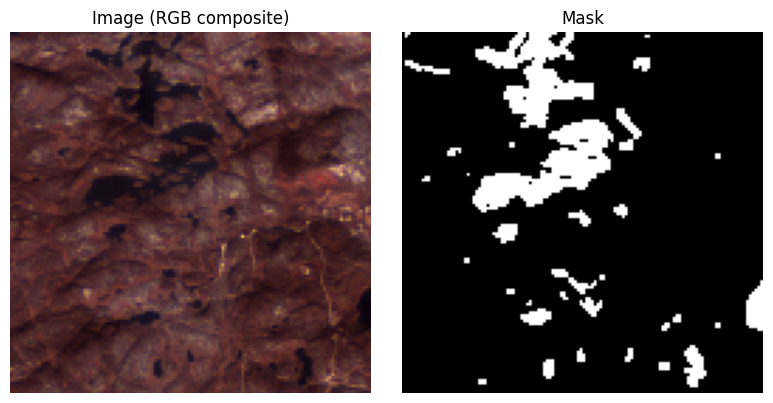

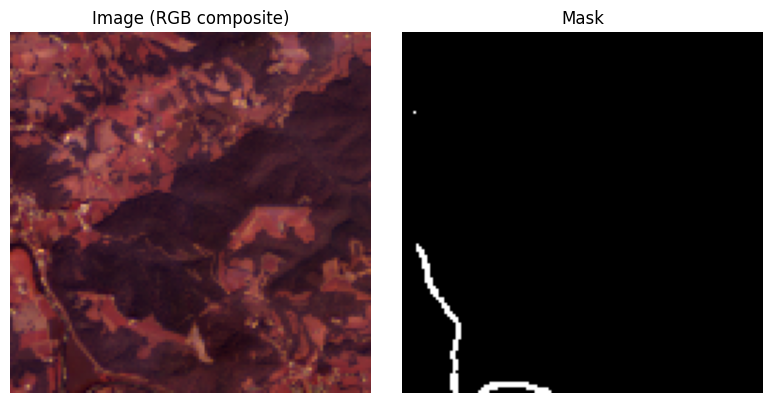

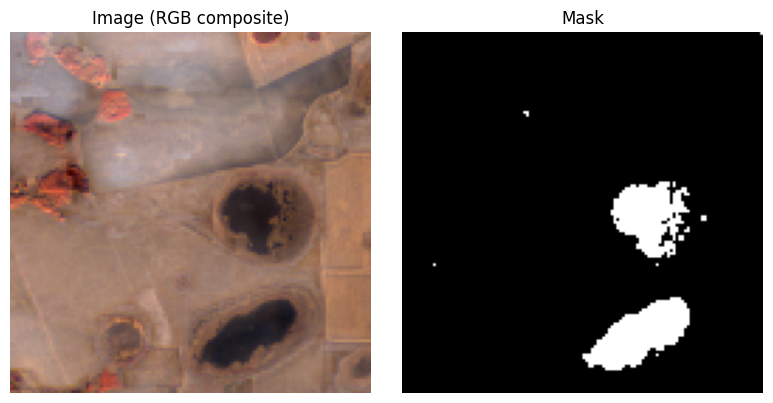

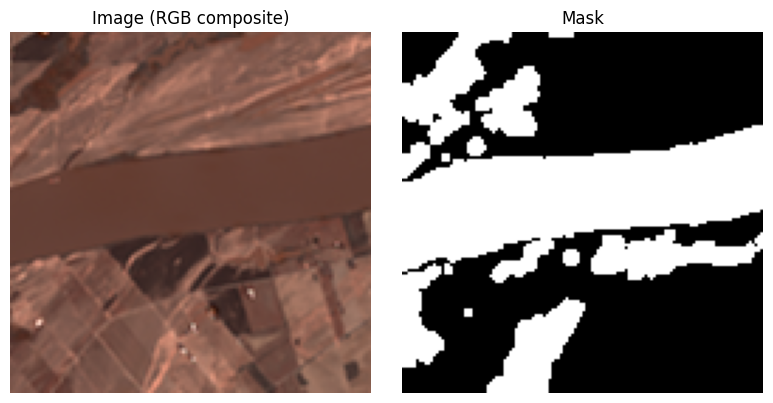

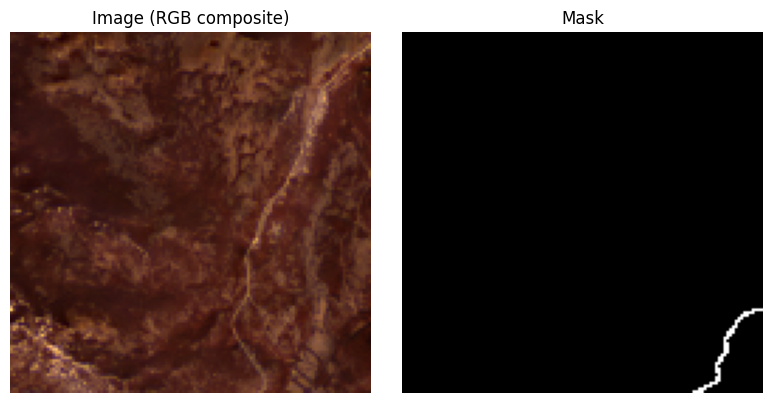

In [ ]:
# Get image and mask filenames and sort them to ensure matching
train_img_files = sorted(os.listdir(output_images))
train_mask_files = sorted(os.listdir(output_labels))

# Check that the number of images matches the number of masks
if len(train_img_files) != len(train_mask_files):
    print("Error: The number of images and masks do not match!")
else:
    # Display only the first 5 image-mask pairs
    for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
        # Construct the full file paths
        img_path = os.path.join(output_images, img_file)
        mask_path = os.path.join(output_labels, mask_file)

        # Display the image and mask together
        display_image_and_mask(img_path, mask_path)

In [ ]:
len(train_img_files)

306

In [ ]:
len(train_mask_files)

306

In [37]:
# Normalize single band for display
def normalize_band(band):
    band = band.astype(np.float32)
    return (band - np.min(band)) / (np.max(band) - np.min(band) + 1e-8)

# Load multi-band .tif
def load_multiband_tif(tif_path):
    img = tifffile.imread(tif_path)
    if img.shape[0] == 12:  # (12, H, W)
        img = np.transpose(img, (1, 2, 0))
    return img

# Load binary mask
def load_mask(mask_path, size=None):
    mask = np.array(Image.open(mask_path))
    if size is not None:
        mask = np.array(Image.fromarray(mask).resize(size, Image.NEAREST))
    return (mask > 0).astype(np.uint8)

# Plot all bands
def plot_all_bands(img, band_names=None):
    h, w, c = img.shape
    if band_names is None:
        band_names = [f"Band {i}" for i in range(c)]

    plt.figure(figsize=(12, 10))
    for i in range(c):
        plt.subplot(4, 3, i + 1)
        plt.imshow(normalize_band(img[..., i]), cmap='gray')
        plt.title(band_names[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot composites with mask overlay
def plot_composites(img, mask=None):
    rgb = img[..., [3, 2, 1]]  # Red, Green, Blue
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

    false_color = img[..., [5, 4, 3]]  # SWIR1, NIR, Red
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    if mask is not None:
        plt.imshow(np.ma.masked_where(mask == 0, mask), cmap='Reds', alpha=0.4)
    plt.title("RGB Composite")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(false_color)
    if mask is not None:
        plt.imshow(np.ma.masked_where(mask == 0, mask), cmap='Reds', alpha=0.4)
    plt.title("False Color (SWIR1-NIR-Red)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


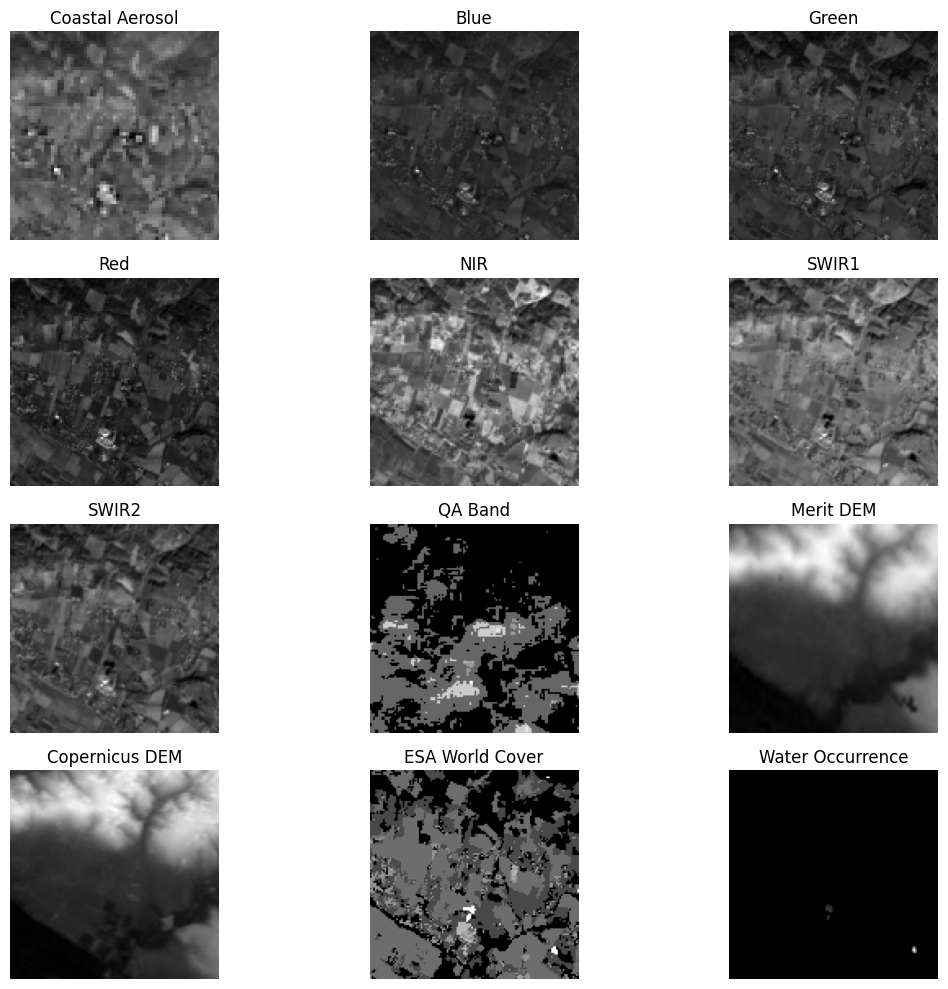

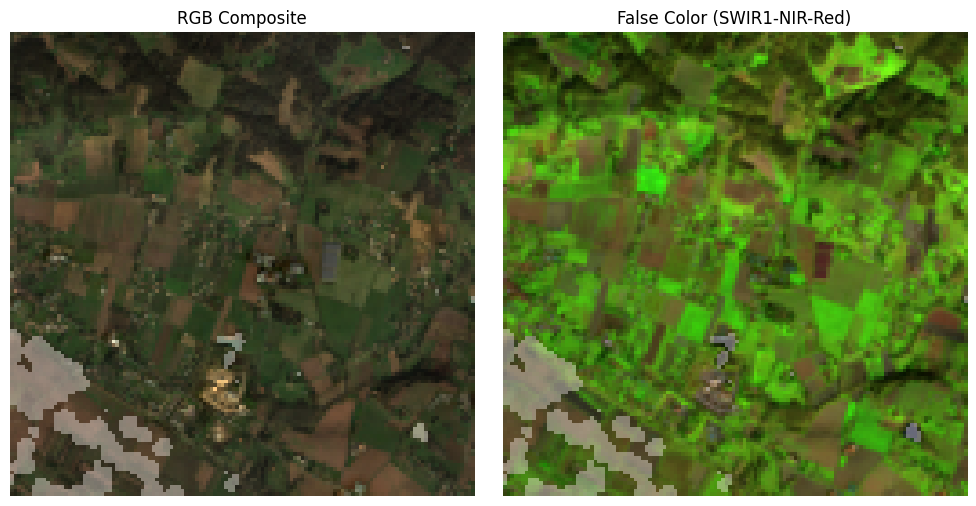

In [39]:
tif_path = "/content/drive/MyDrive/Cellula internship/floods/final_images/3.tif"
mask_path = "/content/drive/MyDrive/Cellula internship/floods/final_mask/3.png"

band_names = [
    "Coastal Aerosol", "Blue", "Green", "Red", "NIR",
    "SWIR1", "SWIR2", "QA Band", "Merit DEM", "Copernicus DEM",
    "ESA World Cover", "Water Occurrence"
]

img = load_multiband_tif(tif_path)
mask = load_mask(mask_path, size=img.shape[:2])

# Plot all bands
plot_all_bands(img, band_names)

# Plot RGB + False Color composites
plot_composites(img, mask)


# New

In [ ]:
class MultiBandDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, img_size=(128, 128), shuffle=True, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs = []
        batch_masks = []

        for i in batch_indices:
            img_path = self.df.loc[i, "image"]
            mask_path = self.df.loc[i, "mask"]

            # Load 12-band TIFF
            img = tifffile.imread(img_path).astype(np.float32)
            if img.shape[0] == 12:
                img = np.transpose(img, (1, 2, 0))  # (H, W, 12)

            # Band-wise normalization
            for b in range(img.shape[-1]):
                band = img[..., b]
                min_val, max_val = band.min(), band.max()
                img[..., b] = (band - min_val) / (max_val - min_val + 1e-8) if max_val > min_val else 0

            # Load mask
            mask = np.array(Image.open(mask_path))
            mask = (mask > 0).astype(np.float32)[..., np.newaxis]

            # Resize both
            if img.shape[:2] != self.img_size:
                img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize(self.img_size, Image.BILINEAR)) / 255.0
                mask = np.array(Image.fromarray(mask.squeeze().astype(np.uint8)).resize(self.img_size, Image.NEAREST))
                mask = mask[..., np.newaxis].astype(np.float32)

            # Apply data augmentation
            if self.augment:
                img, mask = self.apply_augmentation(img, mask)

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

    def apply_augmentation(self, img, mask):
        # Random horizontal flip
        if random.random() > 0.5:
            img = np.flip(img, axis=1)
            mask = np.flip(mask, axis=1)

        # Random vertical flip
        if random.random() > 0.5:
            img = np.flip(img, axis=0)
            mask = np.flip(mask, axis=0)

        # Random 90-degree rotations
        k = random.choice([0, 1, 2, 3])
        if k > 0:
            img = np.rot90(img, k, axes=(0, 1))
            mask = np.rot90(mask, k, axes=(0, 1))

        # Random brightness scaling (per band)
        if random.random() > 0.5:
            scale = 0.9 + random.random() * 0.2  # between 0.9 and 1.1
            img = np.clip(img * scale, 0, 1)

        return img, mask



In [43]:
# Create DataFrame with paths
images = [os.path.join(output_images, file) for file in os.listdir(output_images)]
masks = [os.path.join(output_labels, file) for file in os.listdir(output_labels)]
data = pd.DataFrame({"image": images, "mask": masks})

# Split
train_df, test_df = train_test_split(data, train_size=0.7, random_state=123, shuffle=True)

# Create generators
train_generator = MultiBandDataGenerator(train_df, batch_size=16, img_size=(128, 128), shuffle=True, augment=True)
test_generator = MultiBandDataGenerator(test_df, batch_size=16, img_size=(128, 128), shuffle=False, augment=False)

# Test shapes
X_batch, Y_batch = train_generator[0]
print(X_batch.shape)  # (16, 128, 128, 12)
print(Y_batch.shape)  # (16, 128, 128, 1)


(16, 128, 128, 12)
(16, 128, 128, 1)


In [44]:
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-8)


In [45]:
model = unet_model(input_size=(128, 128, 12))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, Precision(name='precision'), Recall(name='recall')])
model.summary()

history = model.fit(
    train_generator,
    epochs=20
)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_114[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ conv2d_115[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_24… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_116[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ conv2d_117[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_25… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_118[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 16, 16,    │          0 │ conv2d_119[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_26… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_120[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 8, 8, 512) │          0 │ conv2d_121[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_27… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_122[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_24 │ (None, 16, 16,    │  2,097,664 │ conv2d_123[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 740ms/step - accuracy: 0.6726 - iou_metric: 0.2654 - loss: 0.7491 - precision: 0.4197 - recall: 0.4598
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.7549 - iou_metric: 0.2987 - loss: 0.5710 - precision: 0.6043 - recall: 0.4460
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.8487 - iou_metric: 0.4510 - loss: 0.3583 - precision: 0.9483 - recall: 0.4678
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.8711 - iou_metric: 0.5780 - loss: 0.3278 - precision: 0.8539 - recall: 0.6407
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8913 - iou_metric: 0.6091 - loss: 0.2933 - precision: 0.9459 - recall: 0.6428
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.8881 - iou_metric: 0.6219 - loss: 0.3210 - precision: 0.8992 - recall: 0.6680
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.8720 - iou_metric: 0.4757 - loss: 0.3321 - precision: 0.9843 - recall

In [47]:
results = model.evaluate(test_generator)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9174 - iou_metric: 0.6616 - loss: 0.2154 - precision: 0.9404 - recall: 0.6920


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


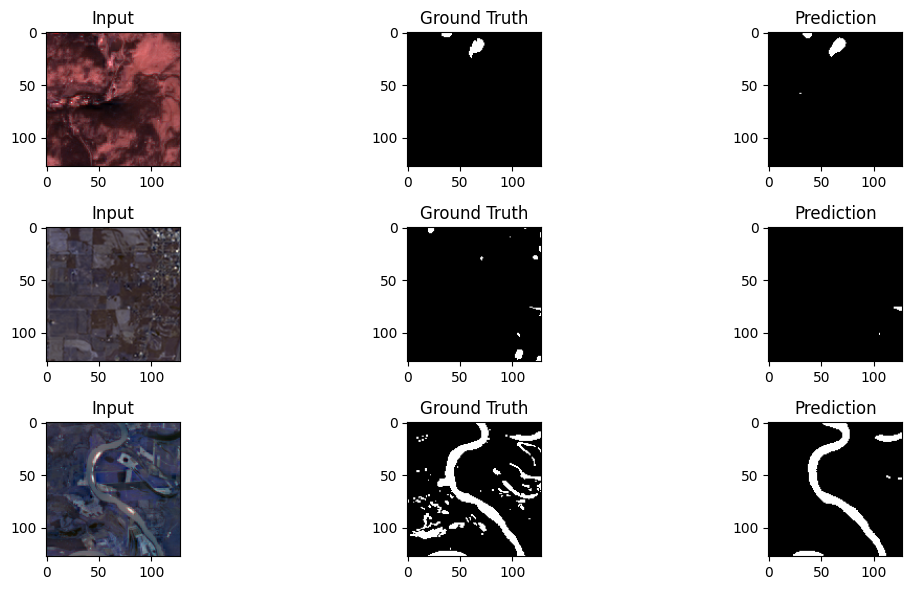

In [48]:
X_val, Y_val = test_generator[4]  # Get first batch
preds = model.predict(X_val)

plt.figure(figsize=(12, 6))
for i in range(3):  # Show first 3 samples
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(X_val[i][..., :3])  # show RGB composite
    plt.title('Input')

    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(3, 3, 3*i + 3)
    plt.imshow((preds[i].squeeze() > 0.5), cmap='gray')
    plt.title('Prediction')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


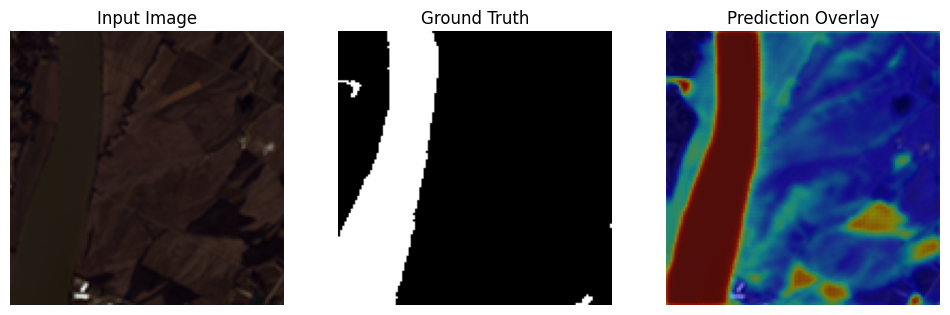

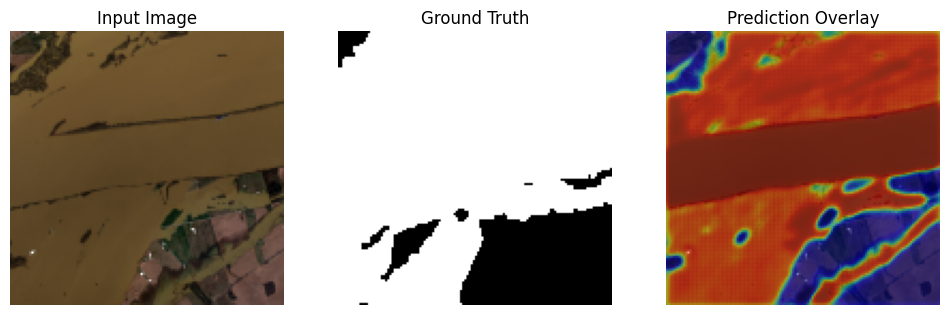

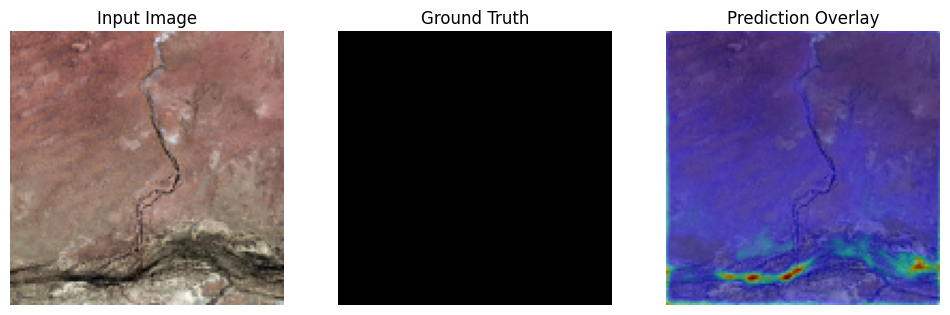

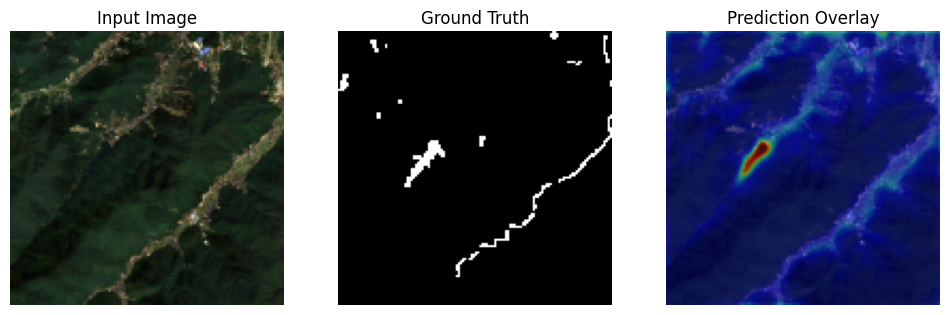

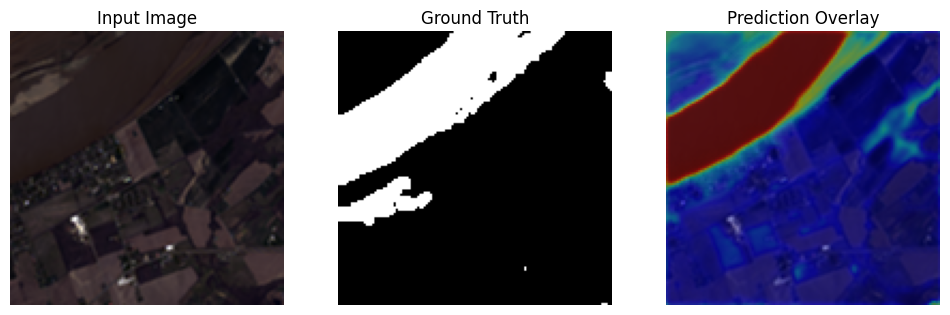

In [50]:
def overlay_predictions(model, generator, alpha=0.5, num_samples=3):
    # Get one batch
    images, masks = next(iter(generator))
    predictions = model.predict(images)

    for i in range(min(num_samples, len(images))):
        img = images[i]

        # If 12-band, select 3 bands (e.g., bands 3, 2, 1) for visualization
        if img.shape[-1] == 12:
            img_vis = img[..., [3, 2, 1]]  # Use near-infrared/RGB
        else:
            img_vis = img

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img_vis)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Prediction Overlay")
        plt.imshow(img_vis)
        plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=alpha)
        plt.axis('off')

        plt.show()
overlay_predictions(model, test_generator, alpha=0.5, num_samples=5)


##Feature_Engineering

In [52]:
class MultiBandDataGenerator_featured(Sequence):
    def __init__(self, dataframe, batch_size=16, img_size=(128, 128), shuffle=True, augment=False):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, batch_masks = [], []

        for i in batch_indices:
            img_path = self.df.loc[i, "image"]
            mask_path = self.df.loc[i, "mask"]

            img = tifffile.imread(img_path).astype(np.float32)
            if img.shape[0] == 12:
                img = np.transpose(img, (1, 2, 0))  # (H, W, 12)

            # Normalize each band individually
            for b in range(img.shape[-1]):
                band = img[..., b]
                min_val, max_val = band.min(), band.max()
                img[..., b] = (band - min_val) / (max_val - min_val + 1e-8) if max_val > min_val else 0

            # ----- FEATURE ENGINEERING -----
            green = img[..., 2]   # Band 3
            nir = img[..., 7]     # Band 8
            swir1 = img[..., 10]  # Band 11
            swir2 = img[..., 11]  # Band 12
            blue = img[..., 1]    # Band 2
            red = img[..., 3]     # Band 4

            # NDWI
            ndwi = (green - nir) / (green + nir + 1e-8)

            # MNDWI
            mndwi = (green - swir1) / (green + swir1 + 1e-8)

            # AWEI (shallow water version, simplified)
            awei = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)

            # Clip to range [0,1] for safety
            ndwi = np.clip((ndwi + 1) / 2, 0, 1)
            mndwi = np.clip((mndwi + 1) / 2, 0, 1)
            awei = np.clip((awei + 1) / 2, 0, 1)

            # Drop red band (index 3)
            img = np.delete(img, 3, axis=-1)

            # Append indices
            img = np.concatenate([img, ndwi[..., np.newaxis], mndwi[..., np.newaxis], awei[..., np.newaxis]], axis=-1)

            # ----- MASK -----
            mask = np.array(Image.open(mask_path))
            mask = (mask > 0).astype(np.float32)[..., np.newaxis]

            # Resize
            if img.shape[:2] != self.img_size:
                img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize(self.img_size, Image.BILINEAR)) / 255.0
                mask = np.array(Image.fromarray(mask.squeeze().astype(np.uint8)).resize(self.img_size, Image.NEAREST))
                mask = mask[..., np.newaxis].astype(np.float32)

            if self.augment:
                img, mask = self.apply_augmentation(img, mask)

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

    def apply_augmentation(self, img, mask):
        if random.random() > 0.5:
            img = np.flip(img, axis=1)
            mask = np.flip(mask, axis=1)
        if random.random() > 0.5:
            img = np.flip(img, axis=0)
            mask = np.flip(mask, axis=0)
        k = random.choice([0, 1, 2, 3])
        if k > 0:
            img = np.rot90(img, k, axes=(0, 1))
            mask = np.rot90(mask, k, axes=(0, 1))
        if random.random() > 0.5:
            scale = 0.9 + random.random() * 0.2
            img = np.clip(img * scale, 0, 1)
        return img, mask


In [56]:
train_generator_featured = MultiBandDataGenerator_featured(train_df, batch_size=16, img_size=(128, 128), shuffle=True, augment=True)
test_generator_featured = MultiBandDataGenerator_featured(test_df, batch_size=16, img_size=(128, 128), shuffle=False, augment=False)


##From Scratch 14 Channel

In [58]:
model_2 = unet_model(input_size=(128, 128, 14))
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, Precision(name='precision'), Recall(name='recall')])
model_2.summary()

history_2 = model_2.fit(
    train_generator_featured,
    epochs=20
)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_171 (Conv2D) │ (None, 128, 128,  │      8,128 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_172 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_171[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 64, 64,    │          0 │ conv2d_172[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_173 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_36… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_174 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_173[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_37    │ (None, 32, 32,    │          0 │ conv2d_174[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_175 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_37… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_175[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (None, 16, 16,    │          0 │ conv2d_176[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_38… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_177[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (None, 8, 8, 512) │          0 │ conv2d_178[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_39… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_179[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_36 │ (None, 16, 16,    │  2,097,664 │ conv2d_180[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,038,081 (118.40 MB)

 Trainable params: 31,038,081 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 659ms/step - accuracy: 0.6648 - iou_metric: 0.1331 - loss: 0.5541 - precision: 0.3083 - recall: 0.2009
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.7316 - iou_metric: 0.3817 - loss: 7.3113 - precision: 0.5356 - recall: 0.5594
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.8272 - iou_metric: 0.2956 - loss: 0.4081 - precision: 0.9962 - recall: 0.3079
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.8317 - iou_metric: 0.3449 - loss: 0.3945 - precision: 0.9946 - recall: 0.3384
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8683 - iou_metric: 0.5231 - loss: 0.3229 - precision: 0.8852 - recall: 0.5703
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.8863 - iou_metric: 0.5722 - loss: 0.2996 - precision: 0.8954 - recall: 0.6211
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8949 - iou_metric: 0.6326 - loss: 0.2834 - precision: 0.8660 - recall

In [61]:
results= model_2.evaluate(test_generator_featured)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step - accuracy: 0.9205 - iou_metric: 0.6707 - loss: 0.2095 - precision: 0.9346 - recall: 0.7085


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


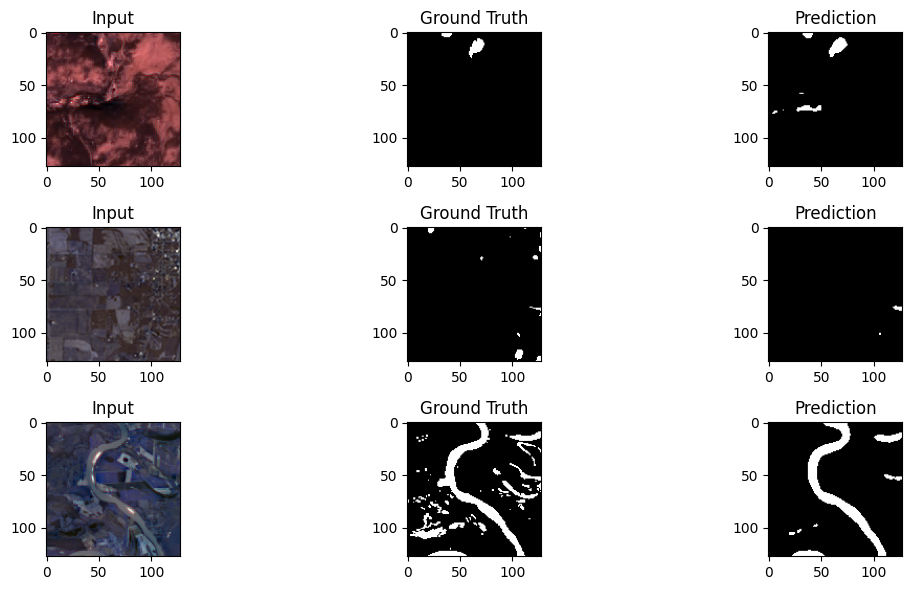

In [63]:
X_val, Y_val = test_generator_featured[4]  # Get first batch
preds_2 = model_2.predict(X_val)

plt.figure(figsize=(12, 6))
for i in range(3):  # Show first 3 samples
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(X_val[i][..., :3])  # show RGB composite
    plt.title('Input')

    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(3, 3, 3*i + 3)
    plt.imshow((preds_2[i].squeeze() > 0.5), cmap='gray')
    plt.title('Prediction')

plt.tight_layout()
plt.show()


##Pretrained_14_Channel

In [ ]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.4 MB/s eta 0:00:00


In [34]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
sm.set_framework('tf.keras')
BACKBONE = 'resnet34'  # Encoder backbone

unet_model = sm.Unet(
    BACKBONE,
    input_shape=(128, 128, 12),
    classes=1,
    activation='sigmoid',
    encoder_weights=None
)

unet_model.compile(
    optimizer=Adam(1e-4),
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score]
)

In [ ]:
train_gen = MultiBandDataGenerator(train_df, batch_size=16)
val_gen = MultiBandDataGenerator(val_df, batch_size=16, shuffle=False)

history = unet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=len(train_df)//16,
    validation_steps=len(val_df)//16
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - f1-score: 0.3836 - iou_score: 0.2388 - loss: 1.3521 - val_f1-score: 0.4112 - val_iou_score: 0.2671 - val_loss: 7.5013
Epoch 2/20
 1/13 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - f1-score: 0.4290 - iou_score: 0.2730 - loss: 1.1457

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - f1-score: 0.4290 - iou_score: 0.2730 - loss: 1.1457 - val_f1-score: 0.4117 - val_iou_score: 0.2675 - val_loss: 7.6313
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 554ms/step - f1-score: 0.4700 - iou_score: 0.3094 - loss: 1.0817 - val_f1-score: 0.4147 - val_iou_score: 0.2694 - val_loss: 4.6157
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - f1-score: 0.3117 - iou_score: 0.1846 - loss: 1.2603 - val_f1-score: 0.4147 - val_iou_score: 0.2694 - val_loss: 4.2332
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 632ms/step - f1-score: 0.5037 - iou_score: 0.3410 - loss: 0.9861 - val_f1-score: 0.4261 - val_iou_score: 0.2787 - val_loss: 2.3174
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - f1-score: 0.5861 - iou_score: 0.4145 - loss: 0.8077 - val_f1-score: 0.4271 - val_iou_score: 0.2794 - val_loss: 2.1232
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - f1-score: 0.5576 - iou_score: 0.3898 - loss: 0.8851 - val_f1-score: 0.4341 - val_iou_score: 0.283

In [ ]:
SELECTED_BANDS = [4, 10, 11]

class ThreeBandDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, img_size=(128, 128), shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, batch_masks = [], []

        for i in batch_indices:
            img_path = self.df.loc[i, "image"]
            mask_path = self.df.loc[i, "mask"]

            # Load 12-band TIFF and select 3 bands
            img = tifffile.imread(img_path).astype(np.float32)
            img = np.transpose(img, (1, 2, 0))  # (H, W, 12)
            img = img[..., SELECTED_BANDS]  # pick 3 bands

            # Normalize each band to [0,1]
            for c in range(img.shape[-1]):
                band = img[..., c]
                img[..., c] = (band - band.min()) / (band.max() - band.min() + 1e-8)

            # Resize
            img = np.array(Image.fromarray((img * 255).astype(np.uint8)).resize(self.img_size, Image.BILINEAR)) / 255.0

            # Load mask
            mask = np.array(Image.open(mask_path).resize(self.img_size, Image.NEAREST))
            mask = (mask > 0).astype(np.float32)[..., np.newaxis]

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)


In [ ]:
train_gen_2= ThreeBandDataGenerator(train_df, batch_size=16)
val_gen_2 = ThreeBandDataGenerator(val_df, batch_size=16, shuffle=False)


In [ ]:
sm.set_framework('tf.keras')

BACKBONE = 'resnet50'

fpn_model = sm.FPN(
    backbone_name=BACKBONE,
    input_shape=(128, 128, 3),
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet'
)

fpn_model.compile(
    optimizer=Adam(1e-4),
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score]
)

fpn_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_106  │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_107  │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_108  │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_1… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, 32, 32,    │          0 │ stage1_unit1_bn3

 Total params: 26,911,818 (102.66 MB)

 Trainable params: 26,863,940 (102.48 MB)

 Non-trainable params: 47,878 (187.02 KB)

In [ ]:
history_2 = fpn_model.fit(
    train_gen_2,
    validation_data=val_gen_2,
    epochs=30,
    steps_per_epoch=len(train_df)//16,
    validation_steps=len(val_df)//16
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - f1-score: 0.5950 - iou_score: 0.4251 - loss: 0.8093 - val_f1-score: 0.3697 - val_iou_score: 0.2322 - val_loss: 1.5595
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - f1-score: 0.6930 - iou_score: 0.5302 - loss: 0.5913 - val_f1-score: 0.3718 - val_iou_score: 0.2340 - val_loss: 1.5847
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - f1-score: 0.6608 - iou_score: 0.4944 - loss: 0.6856 - val_f1-score: 0.3590 - val_iou_score: 0.2237 - val_loss: 1.5220
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - f1-score: 0.5883 - iou_score: 0.4168 - loss: 0.7714 - val_f1-score: 0.3593 - val_iou_score: 0.2239 - val_loss: 1.5248
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - f1-score: 0.6557 - iou_score: 0.4919 - loss: 0.6708 - val_f1-score: 0.3474 - val_iou_score: 0.2142 - val_loss: 1.4107
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - f1-score: 0.6790 - iou_score: 0.5140 - loss: 0.6357 - val_f1-score: 0.3431 - val_iou_scor

#Pretrained after Feature Engineering

##RESNET34

In [69]:
from segmentation_models import Unet
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
import tensorflow as tf

class CustomUNet14(Model):
    def __init__(self, input_shape=(128, 128, 14), backbone='resnet34'):
        super(CustomUNet14, self).__init__()

        # 14-channel base model (no weights yet)
        self.base = Unet(backbone_name=backbone, input_shape=input_shape,
                         encoder_weights=None, classes=1, activation='sigmoid')

        # Load pretrained 3-channel model
        base_weights = Unet(backbone_name=backbone, input_shape=(128, 128, 3),
                            encoder_weights='imagenet', classes=1, activation='sigmoid')

        # Transfer weights except first 3 layers
        for i in range(3, len(self.base.layers)):
            try:
                self.base.layers[i].set_weights(base_weights.layers[i].get_weights())
            except:
                print(f"Skipping layer {i}: {self.base.layers[i].name}")

        del base_weights

    def call(self, x, training=None):
        return self.base(x)


In [72]:
model_3 = CustomUNet14(input_shape=(128, 128, 14), backbone='resnet34')
model_3.build(input_shape=(None, 128, 128, 14))


Skipping layer 3: conv0


In [74]:
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, Precision(name='precision'), Recall(name='recall')])
model_3.summary()

history_3 = model_3.fit(
    train_generator_featured,
    epochs=40
)

Model: "custom_u_net14_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_22 (Functional)      │ (None, 128, 128, 1)    │    24,490,683 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,490,683 (93.42 MB)

 Trainable params: 24,473,311 (93.36 MB)

 Non-trainable params: 17,372 (67.86 KB)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9085 - iou_metric: 0.6171 - loss: 0.2174 - precision: 0.8679 - recall: 0.6877
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.9003 - iou_metric: 0.6731 - loss: 0.2292 - precision: 0.8209 - recall: 0.7917
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9123 - iou_metric: 0.7109 - loss: 0.2194 - precision: 0.8942 - recall: 0.7669
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9059 - iou_metric: 0.6527 - loss: 0.2215 - precision: 0.8479 - recall: 0.7393
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9018 - iou_metric: 0.6351 - loss: 0.2268 - precision: 0.9067 - recall: 0.6992
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.9117 - iou_metric: 0.6706 - loss: 0.2058 - precision: 0.8881 - recall: 0.7374
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9045 - iou_metric: 0.6577 - loss: 0.2189 - precision: 0.8580 - recall: 0

In [76]:
results=model_3.evaluate(test_generator_featured)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9097 - iou_metric: 0.6739 - loss: 0.3750 - precision: 0.8034 - recall: 0.8167


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


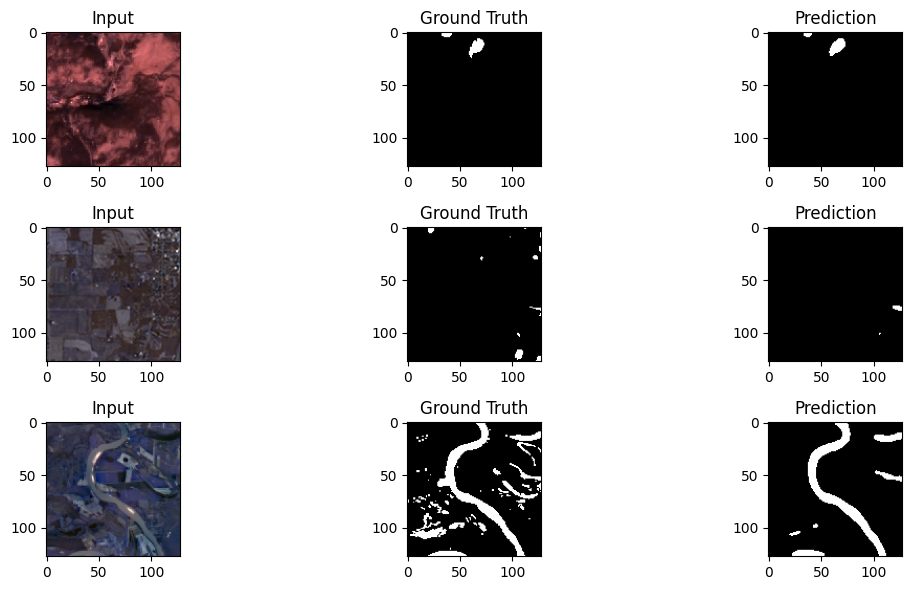

In [80]:
X_val, Y_val = test_generator_featured[4]  # Get first batch
preds_3 = model_3.predict(X_val)

plt.figure(figsize=(12, 6))
for i in range(3):  # Show first 3 samples
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(X_val[i][..., :3])  # show RGB composite
    plt.title('Input')

    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(3, 3, 3*i + 3)
    plt.imshow((preds_3[i].squeeze() > 0.5), cmap='gray')
    plt.title('Prediction')

plt.tight_layout()
plt.show()


In [81]:
model_3.save('model_RESNET43_14.keras')

##FPN 14


In [93]:
from segmentation_models import FPN
import tensorflow as tf

class CustomFPN14(Model):
    def __init__(self, input_shape=(128, 128, 14), backbone='resnet50'):
        super(CustomFPN14, self).__init__()

        # 14-channel base model (no weights yet)
        self.base = FPN(backbone_name=backbone, input_shape=input_shape,
                         encoder_weights=None, classes=1, activation='sigmoid')

        # Load pretrained 3-channel model
        base_weights = FPN(backbone_name=backbone, input_shape=(128, 128, 3),
                            encoder_weights='imagenet', classes=1, activation='sigmoid')

        # Transfer weights except first 3 layers
        for i in range(1, len(self.base.layers)):
            try:
                self.base.layers[i].set_weights(base_weights.layers[i].get_weights())
            except:
                print(f"Skipping layer {i}: {self.base.layers[i].name}")

        del base_weights

    def call(self, x, training=None):
        return self.base(x)



In [94]:
model_4 = CustomFPN14(input_shape=(128, 128, 14), backbone='resnet50')
model_4.build(input_shape=(None, 128, 128, 14))

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Skipping layer 1: bn_data
Skipping layer 3: conv0


In [95]:
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, Precision(name='precision'), Recall(name='recall')])
model_4.summary()

history_4 = model_4.fit(
    train_generator_featured,
    epochs=40
)

Model: "custom_fpn14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_48 (Functional)      │ (None, 128, 128, 1)    │    26,946,347 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,946,347 (102.79 MB)

 Trainable params: 26,898,447 (102.61 MB)

 Non-trainable params: 47,900 (187.11 KB)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.6332 - iou_metric: 0.2990 - loss: 0.7512 - precision: 0.4010 - recall: 0.5895
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.8505 - iou_metric: 0.4895 - loss: 0.3636 - precision: 0.7494 - recall: 0.5973
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.8642 - iou_metric: 0.5548 - loss: 0.3090 - precision: 0.7889 - recall: 0.6551
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.8681 - iou_metric: 0.5381 - loss: 0.3174 - precision: 0.8152 - recall: 0.6058
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.8791 - iou_metric: 0.5849 - loss: 0.2747 - precision: 0.8012 - recall: 0.6852
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - accuracy: 0.9111 - iou_metric: 0.6797 - loss: 0.2379 - precision: 0.9080 - recall: 0.7109
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9057 - iou_metric: 0.6723 - loss: 0.2371 - precision: 0.8791 - recall: 

In [101]:
model_4.evaluate(test_generator_featured)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 971ms/step - accuracy: 0.8953 - iou_metric: 0.6333 - loss: 0.2805 - precision: 0.7398 - recall: 0.8429


[0.29190632700920105,
 0.8886579275131226,
 0.6515026092529297,
 0.7662377953529358,
 0.8445357084274292]

In [ ]:
model_4.save('model_FPN50_14.keras')

In [102]:
model_5 = CustomFPN14(input_shape=(128, 128, 14), backbone='resnext50')
model_5.build(input_shape=(None, 128, 128, 14))

94428600/94428600 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Skipping layer 1: bn_data
Skipping layer 3: conv0


In [ ]:
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric, Precision(name='precision'), Recall(name='recall')])
model_5.summary()

history_5 = model_5.fit(
    train_generator_featured,
    epochs=40
)

Model: "custom_fpn14_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_54 (Functional)      │ (None, 128, 128, 1)    │    26,448,427 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,448,427 (100.89 MB)

 Trainable params: 26,377,871 (100.62 MB)

 Non-trainable params: 70,556 (275.61 KB)

Epoch 1/40


In [100]:
results=model_5.evaluate(test_generator_featured)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.7783 - iou_metric: 0.0449 - loss: 1.8549 - precision: 0.9557 - recall: 0.0600
